### PROJECT TITLE: 
##### SHARP TURN DETECTION LOGIC FOR TRUCKS

### INTRODUCTION: 
##### Sharp turns pose rollover and accident risks for trucks due to their size. 
##### Detecting sharp turn events allows preemptive safety measures, including driver warnings and stability control activation.

### METHODS: 
##### 1. No Aggregation & Radius Estimated from Truck Length



--------------------------------------------------

#### ALL REQUIRED LIBRARIES

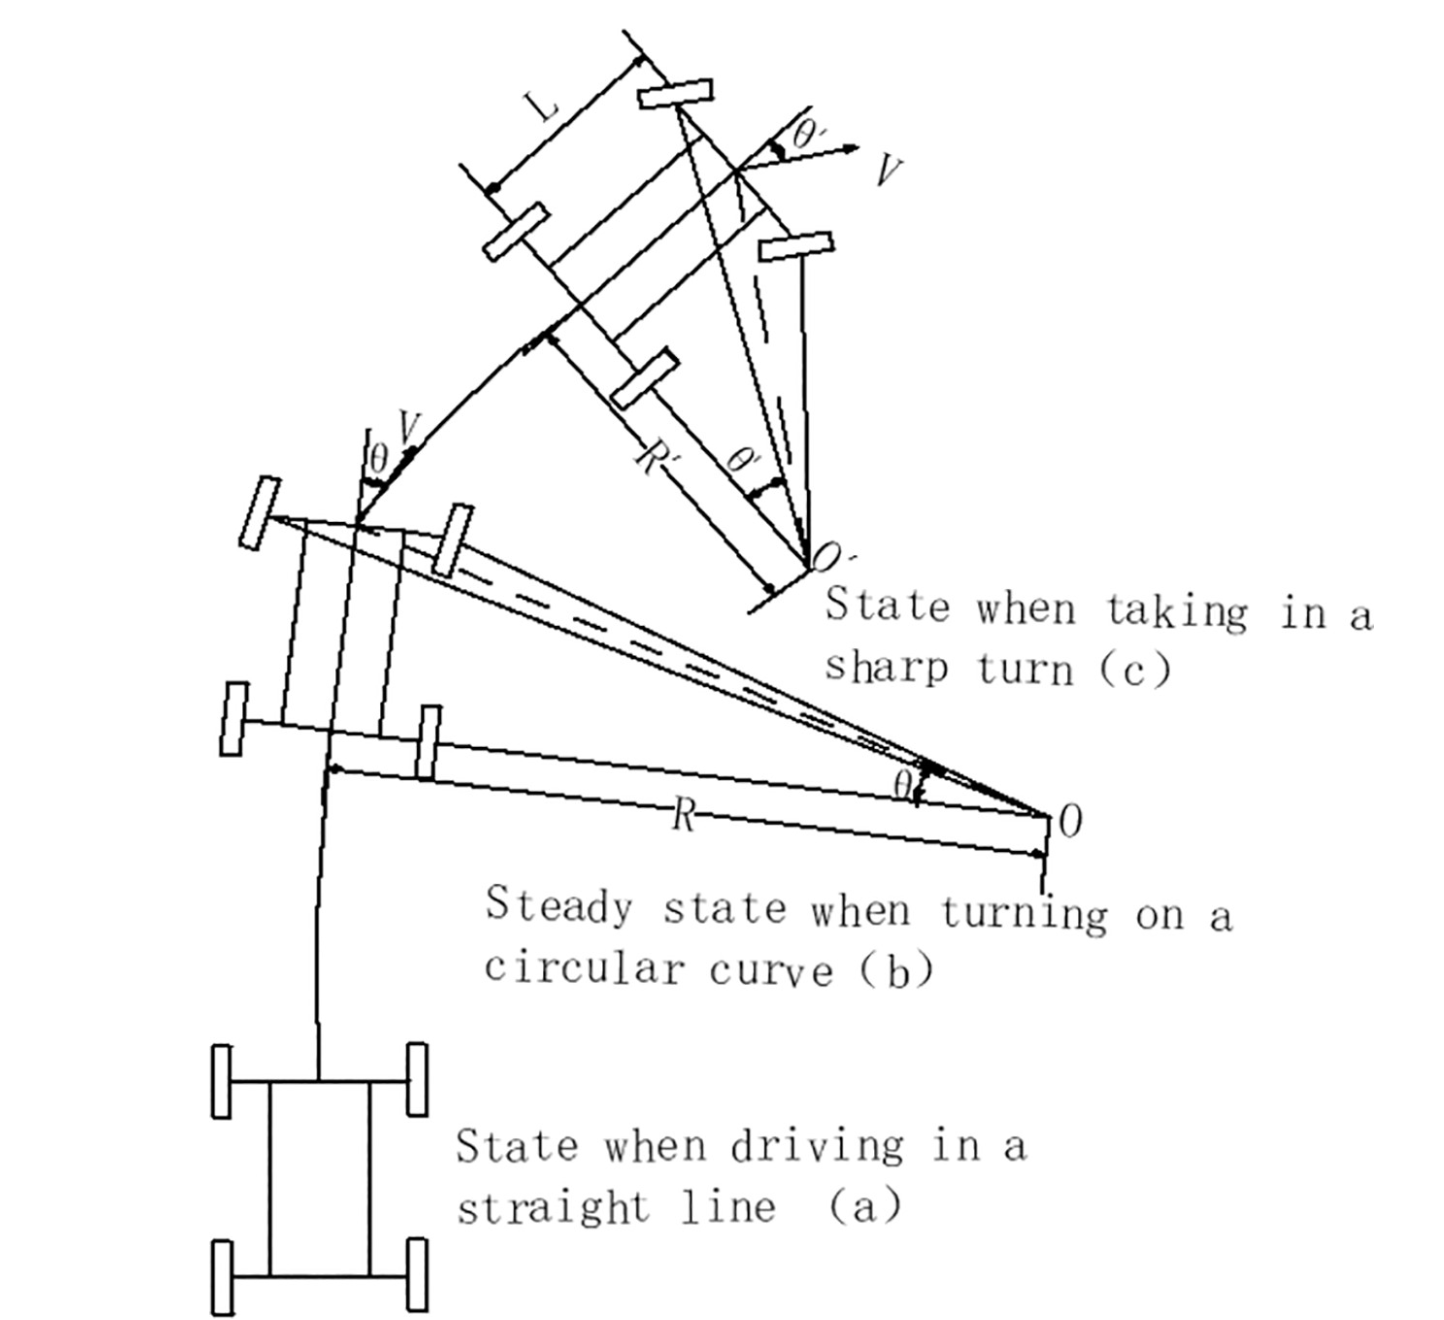

In [162]:
import numpy as np                              
import pandas as pd                            
import matplotlib.pyplot as plt
from IPython.display import Image, display

from datetime import datetime                                                                        
from math import radians, cos, sin, asin, sqrt
import math
import warnings 
warnings.filterwarnings('ignore')

display(Image(filename='../Images/Radius_of_curve.png', width=600, height=100))


------

### MODEL ASSUMPTIONS 

#### - Investigation and analysis is centered around Conventional Truck heads and Reefers

#### - Typical height of center of gravity of truck head is 0.8 m range (0.6 - 0.9)
#### - Typical truck head weight - 9071.84 Kg (20,000 lbs)
#### - Typical trailer weight and loading conditions
    Empty - 6123 kg (13,500 lbs) 

    Partially Full 14,000 kg (30,864.7lbs)

    Full - 22679.619 kg (50,000 lbs)

#### Superelevation of road to calculate center of gravity is 0.35m

#### Formula for estimating constants for Height of Center of Gravity (HCG) of Typical Truck type

$$\theta = \sin^{-1}(\frac{h}{L})$$
$$\gamma = \cot(\theta)$$
$$h = [b-L(\frac{R_{rl}}{w})]\gamma + r $$


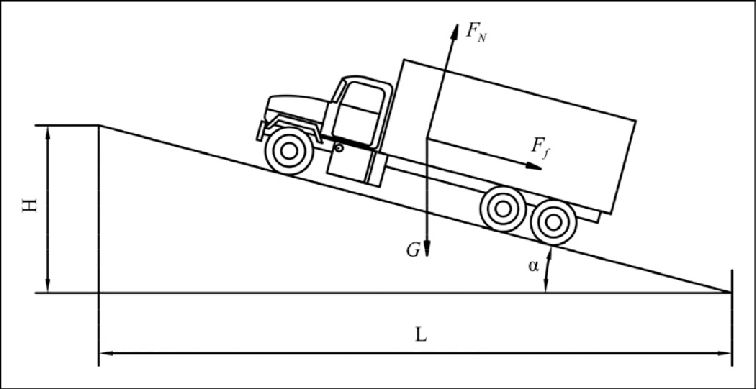

In [163]:
display(Image(filename='../Images/hcg_image.png', width=500, height=200))

In [164]:
mass_truckhead = 9071.85
mass_reeftrailor = 22679.619
semi_trackwidth =  2.47
height_of_center_of_gravity_truckhead = 0.8
height_of_center_of_gravity_trailer = 1.35
gravity = 9.81
truck_length = 25

---

#### LOADING AND EXPLORING THE ELD DATA

    Write more about the datasource and composition.

In [165]:
headers = ['timestamp','latitude','longitude','direction','vehicle_motion_status','speed_mph','acceleration_from_gps_speed']
gps_df = pd.read_csv('../sample_gps_data/sim.csv')
gps_df.columns = headers
gps_df_10 = gps_df.copy() #  Creating a copy of the dataframe to be used in subsequent methods
gps_df_cav = gps_df.copy() #  Creating a copy of the dataframe to be used in subsequent methods
gps_df.head(4)

,timestamp,latitude,longitude,direction,vehicle_motion_status,speed_mph,acceleration_from_gps_speed
0,2023-11-20 10:50:34.000,42.35762,-83.11444,123.68,MOVING,74.0,-0.42
1,2023-11-20 10:50:35.000,42.35745,-83.11412,123.45,MOVING,72.9,-0.47
2,2023-11-20 10:50:36.000,42.35730,-83.11381,123.27,MOVING,72.9,0.00
3,2023-11-20 10:50:37.000,42.35712,-83.11349,123.49,MOVING,72.5,-0.19


In [166]:
# Simulated Sharp Turn Event
def simulateData(df):

    anomaly_indices = np.random.choice(df.index, size=10000, replace=False)
    previous_headings = df.loc[anomaly_indices, 'direction']
    new_headings = np.random.uniform(low=previous_headings - 10, high=previous_headings + 10)

    df.loc[anomaly_indices, 'direction'] = new_headings

    df.to_csv('simulatedData.csv', index=False)

    return 'Simulated csv saved successfully'

In [167]:
simulateData(gps_df)

'Simulated csv saved successfully'

#### DATA PROCESSING AND FEATURE ENGINEERING

In [169]:
def date_time(date_time_str):
    # Convert the date-time string to a usable format
    t = str(date_time_str)
    # Split the string to separate date and time parts
    parts = t.split('.')
    
    # Extract the date and time information
    clean = parts[0].split(' ')
    date_parts = clean[0].split('-')
    time_parts = clean[1].split(':')
    
    # Convert date and time parts to integers
    date_parts = map(int, date_parts)
    time_parts = map(int, time_parts)

    # Extract individual components (year, month, day, hour, minute, second)
    year, month, day = date_parts
    hour, minute, second = time_parts
    
    # Create a datetime object
    date_time_obj = datetime(year, month, day, hour, minute, second)

    # Calculate the total seconds since the Unix epoch (1970-01-01)
    total_seconds = (date_time_obj - datetime(1970, 1, 1)).total_seconds()
    
    return total_seconds


In [170]:
def angular_distance(angle1, angle2):
    # Ensure both angles are between 0 and 360 degrees
    angle1 = angle1 % 360.0
    angle2 = angle2 % 360.0
    
    # Calculate the absolute angular distance
    distance = abs(angle1 - angle2)
    
    # Take the minimum of the direct distance and the wrapped-around distance
    distance = min(distance, 360.0 - distance)
    
    # Convert to radians
    distance_radians = distance * (np.pi / 180)
    
    # Return the calculated angular distance in radians
    return distance_radians

In [171]:
# Shift the direction column to get the previous heading
gps_df['previous_heading'] = gps_df['direction'].shift()

# Calculate the angular distance between consecutive headings
gps_df['angular_distance'] = gps_df.apply(lambda row: angular_distance(row['previous_heading'], row['direction']), axis=1)

# Calculate angular velocity (angularV) using the angular distance and time difference
gps_df["angularV"] = (gps_df.angular_distance) / gps_df.timestamp.apply(date_time).diff()

# Drop the columns not required further and temporary column used for calculating angular distance
# gps_df.drop(columns=['latitude','longitude','acceleration_from_gps_speed','previous_heading'],inplace=True)
gps_df.drop(columns=['latitude','longitude','previous_heading'],inplace=True)

# Display the first 4 rows of the DataFrame
gps_df.head(4)

,timestamp,direction,vehicle_motion_status,speed_mph,acceleration_from_gps_speed,angular_distance,angularV
0,2023-11-20 10:50:34.000,123.68,MOVING,74.0,-0.42,NaN,NaN
1,2023-11-20 10:50:35.000,123.45,MOVING,72.9,-0.47,0.004014,0.004014
2,2023-11-20 10:50:36.000,123.27,MOVING,72.9,0.00,0.003142,0.003142
3,2023-11-20 10:50:37.000,123.49,MOVING,72.5,-0.19,0.003840,0.003840


#### ESTIMATING RADIUS OF CURVE - R FROM ELD DATA

### $$r = v/w$$
##### r = radius
##### v = speed in m/s
##### w = angular velocity

In [172]:
def find_curve_radius(angle_degrees, truck_length=truck_length):
    # Calculate the adjacent side of a right-angled triangle using the tangent of the angle
    # Adding a small value (0.00001) to avoid division by zero
    curve_radius = truck_length / (math.tan(angle_degrees) + 0.00001)
    
    # Return the absolute value of the result
    return np.abs(curve_radius)

In [173]:
# Convert speed from mph to m/s
gps_df['speed_mps'] = gps_df['speed_mph'] * 0.44704

# Calculate curve radius using angular velocity
gps_df['CurveRadius'] = np.abs(gps_df['speed_mps'] ** 2 / gps_df['acceleration_from_gps_speed'])

# Calculate radius based on angular distance using the find_adjacent function
gps_df['radius'] = gps_df['angular_distance'].apply(find_curve_radius)

#### ESTIMATING TOTAL HEIGHT OF CENTER OF GRAVITY

$$h_{cm}=\frac{m_{truck}\cdot h_{truck} + m_{trailor} \cdot h_{trailor}}{m_{trailor}+m_{truck}}$$

In [175]:
h_cg = (mass_truckhead * height_of_center_of_gravity_truckhead \
        + mass_reeftrailor  * height_of_center_of_gravity_trailer)\
            /(mass_truckhead + mass_reeftrailor)

#### ESTIMATING THE THRESHOLD SPEED (V) FOR TYPICAL TRUCK TYPE

$$v_{\text{crit}} = \sqrt{\frac{g \cdot T}{2H_{cg}} \cdot r}$$

$$v_{\text{crit}} = \sqrt{127 \cdot R \cdot ({U_y} + {I_h})}$$

Where:  g = $9.81$, ${H_{cg}}$ = height of center of mass, T = track width of each truck


In [176]:
def critical_speed(radius, height=h_cg, track_width=semi_trackwidth):
    """Calculates the critical speed based on given parameters.

    Args:
        radius (float): Radius in meters.
        height (float): Height in meters.
        track_width (float): Track width in meters.

    Returns:
        float: Critical speed value in miles per hour.
    """
    g = 9.81
    # Calculate critical speed in m/s
    crit_speed = np.sqrt((g * track_width) / (2 * height) * radius)
    # Convert to miles per hour
    critical_speed_mph = crit_speed * 2.23694
    return critical_speed_mph


### METHOD 1  - NO AGGREGATION & USING RADIUS ESTIMATED FROM TRUCK LENGTH

In [177]:
# Calculate critical speed for each data point
gps_df['critical_speed'] = gps_df['radius'].apply(critical_speed)

# Create a column 'result' based on the condition: 85% of critical speed
gps_df['result'] = np.where(gps_df.critical_speed * 0.85 <= gps_df['speed_mph'], 1, 0)

# Display the first 4 rows of the dataframe
gps_df.head(4)

,timestamp,direction,vehicle_motion_status,speed_mph,acceleration_from_gps_speed,angular_distance,angularV,speed_mps,CurveRadius,radius,critical_speed,result
0,2023-11-20 10:50:34.000,123.68,MOVING,74.0,-0.42,NaN,NaN,33.080960,2605.595035,NaN,NaN,0
1,2023-11-20 10:50:35.000,123.45,MOVING,72.9,-0.47,0.004014,0.004014,32.589216,2259.695744,6212.293179,561.893589,0
2,2023-11-20 10:50:36.000,123.27,MOVING,72.9,0.00,0.003142,0.003142,32.589216,inf,7932.471218,634.939518,0
3,2023-11-20 10:50:37.000,123.49,MOVING,72.5,-0.19,0.003840,0.003840,32.410400,5528.600148,6493.939606,574.489676,0


#### RESULTS AND CONCLUSION

In [178]:
# Find indices where 'result' is 1
indices_with_one = np.where(gps_df.result == 1)[0]

# Print statistics
print(f'Total Sharp Turns: --> {len(indices_with_one)}')
print(f'Total Hours: --> {len(gps_df) / 3600:.02f} Hrs')
print(f'Percentage: --> {(len(indices_with_one) / len(gps_df) * 100):.02f} %')

Total Sharp Turns: --> 590
Total Hours: --> 20.73 Hrs
Percentage: --> 0.79 %



### Conclusion
    - With this method we returned some positive results indicating sharp turns with significant change in heading

---

### METHOD 2  -  DESIGNING A SHARPTURN PREDICTION MODEL

In [179]:
# Data manipulation, visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

---

#### DATA EXPLORATION AND VISUALIZATION

In [180]:
gps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74622 entries, 0 to 74621
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   timestamp                    74622 non-null  object 
 1   direction                    74622 non-null  float64
 2   vehicle_motion_status        74622 non-null  object 
 3   speed_mph                    74622 non-null  float64
 4   acceleration_from_gps_speed  74622 non-null  float64
 5   angular_distance             74621 non-null  float64
 6   angularV                     74488 non-null  float64
 7   speed_mps                    74622 non-null  float64
 8   CurveRadius                  35675 non-null  float64
 9   radius                       74621 non-null  float64
 10  critical_speed               74621 non-null  float64
 11  result                       74622 non-null  int64  
dtypes: float64(9), int64(1), object(2)
memory usage: 6.8+ MB


    Create a new column called sharpturn_label to be Yes or No

In [181]:
gps_df['sharpturn_label'] = np.where(gps_df['result']==1, 'Yes', 'No')
gps_df.head(5)

,timestamp,direction,vehicle_motion_status,speed_mph,acceleration_from_gps_speed,angular_distance,angularV,speed_mps,CurveRadius,radius,critical_speed,result,sharpturn_label
0,2023-11-20 10:50:34.000,123.68,MOVING,74.0,-0.42,NaN,NaN,33.080960,2605.595035,NaN,NaN,0,No
1,2023-11-20 10:50:35.000,123.45,MOVING,72.9,-0.47,0.004014,0.004014,32.589216,2259.695744,6212.293179,561.893589,0,No
2,2023-11-20 10:50:36.000,123.27,MOVING,72.9,0.00,0.003142,0.003142,32.589216,inf,7932.471218,634.939518,0,No
3,2023-11-20 10:50:37.000,123.49,MOVING,72.5,-0.19,0.003840,0.003840,32.410400,5528.600148,6493.939606,574.489676,0,No
4,2023-11-20 10:50:38.000,123.98,MOVING,73.5,0.46,0.008552,0.008552,32.857440,2346.981225,2919.768782,385.214243,0,No


In [182]:
slide_df = gps_df[['direction', 'vehicle_motion_status', 'speed_mph',
       'acceleration_from_gps_speed', 'radius',
       'critical_speed', 'sharpturn_label']][1:]
slide_df.head()

,direction,vehicle_motion_status,speed_mph,acceleration_from_gps_speed,radius,critical_speed,sharpturn_label
1,123.45,MOVING,72.9,-0.47,6212.293179,561.893589,No
2,123.27,MOVING,72.9,0.00,7932.471218,634.939518,No
3,123.49,MOVING,72.5,-0.19,6493.939606,574.489676,No
4,123.98,MOVING,73.5,0.46,2919.768782,385.214243,No
5,123.88,MOVING,74.4,0.41,14242.327889,850.782593,No


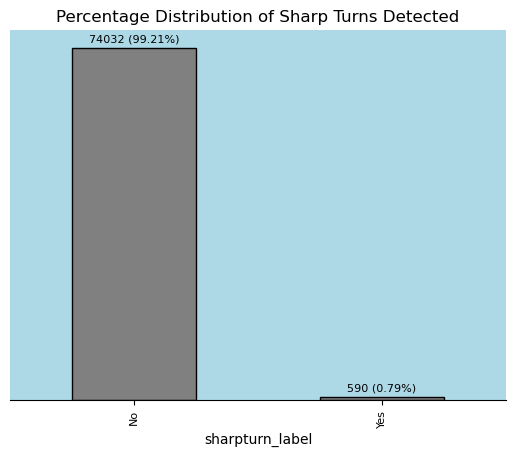

In [183]:
def visualize_barchart(df, group_col, count_col, title):
    # Group by the specified column and count occurrences
    grouped_df = df.groupby(group_col)[count_col].count()

    # Calculate percentage distribution
    percentage_distribution = (grouped_df / grouped_df.sum()) * 100

    # Plot the bar chart
  
    ax = percentage_distribution.plot(kind='bar', color='gray', edgecolor='black', title=title, fontsize=8)

    # Add percentage labels on top of each bar
    for idx, (count,value) in enumerate(zip(grouped_df,percentage_distribution)):
        ax.text(idx, value + 1 , f'{count} ({value:.2f}%)', ha='center', va='bottom', fontsize=8, color='black')

    # Remove y-axis
    ax.yaxis.set_visible(False)

    # Show the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().set_facecolor('lightblue')
    plt.show()

# Example usage
visualize_barchart(gps_df, 'sharpturn_label', 'sharpturn_label', 'Percentage Distribution of Sharp Turns Detected')


    The above visualization explicitly shows the level of imbalance in the target column - sharpturn_label. There is a massive skew in the distribution of sharturn = Yes and sharpturn = No which will affect the model performance as our aim is to place more importance on predicting Yes.

    This imbalance poses a challenge for this model that will results in a poor predictive performance, specifically for the minority class. 
    For our case the minority class - sharpturn_label = Yes is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class.

    Solution:
    To address this class imbalance we will resample the training dataset by introducing Random oversampling method. This will in effect allow for the minority class to be randomly duplicated.


    Create X - features and y - target while dropping unnecessary columns.

In [184]:
gps_df.drop(['timestamp', 'angularV', 'speed_mps', 'CurveRadius', 'result'], axis=1, inplace=True)
X = gps_df.drop('sharpturn_label', axis= 1)[1:]
y = gps_df.sharpturn_label[1:]

    DATA PROCESSING - ENCODING & SCALING THE FEATURES AND TARGET COLUMNS

In [185]:
X = pd.get_dummies(X, columns=['vehicle_motion_status'])

In [186]:
# Function to Encode target (y) dataset
def encode_target(target: np.array) -> np.array:
  """
  Encode target labels using label encoding.

  Parameters:
  - target (numpy.array): The input array containing target labels.

  Returns:
  - encoded_target (numpy.array): The label encoded target labels.
  """

  # Create an instance of LabelEncoder
  label_encoder = LabelEncoder()

  # Fit and transform the target array
  encoded_target = label_encoder.fit_transform(target)

  return encoded_target

In [187]:
y = encode_target(y)

print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 74031, 1: 590})


    Split the dataset to train - 80% & test - 20%

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

    Scale (Normalize) the train and test features

In [189]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

    Introduce random oversampling to balance the target variable

In [190]:
oversampler = RandomOverSampler(random_state=13)
X_train_resample, y_train_resample = oversampler.fit_resample(X_train, y_train)

In [191]:
# smote = SMOTE(sampling_strategy=.5, k_neighbors=1, random_state=13)
# X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [192]:
print('-'*45+'\nCLASS PROPORTION'+'\n'+'-'*45,
      f'\nBefore resampling: {Counter(y_train)}',
      f'\nAfter resampling : {Counter(y_train_resample)}')

---------------------------------------------
CLASS PROPORTION
--------------------------------------------- 
Before resampling: Counter({0: 59221, 1: 475}) 
After resampling : Counter({0: 59221, 1: 59221})


In [193]:
print(f'SAMPLE FEATURES:\n{X_train_resample[0]}',
      f'\n\nSAMPLE TARGETS:\n{y_train_resample[:30]}')

SAMPLE FEATURES:
[-0.45989671  0.72166991 -2.05343436 -0.26763159 -0.82867175 -0.83018105
 -0.18695309  1.06753997 -0.99772438] 

SAMPLE TARGETS:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


    LOGISTIC REGRESSION - Train the model

In [194]:
lgr = LogisticRegression(random_state=13)
lgr.fit(X_train_resample, y_train_resample)

LogisticRegression(random_state=13)

    Predict on the test set

In [195]:
lgr_pred = lgr.predict(X_test)

    Model Evaluation and report

In [196]:
lgr_report = classification_report(y_test, lgr_pred, digits=4, output_dict=True)
print(classification_report(y_test, lgr_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9799    0.9899     14810
           1     0.2791    1.0000    0.4364       115

    accuracy                         0.9801     14925
   macro avg     0.6396    0.9900    0.7132     14925
weighted avg     0.9944    0.9801    0.9856     14925



DECISION TREE CLASSIFIER - Train model

In [208]:
random_noise = np.random.random(size=(X_train_resample.shape[0], 1))

# Add random noise column to X_train_resample
X_train_resample_with_noise = np.concatenate((X_train_resample, random_noise), axis=1)
dfr = pd.DataFrame(X_train_resample_with_noise, columns=X.columns.tolist() + ['random_noise'])
dfr.columns

Index(['direction', 'speed_mph', 'acceleration_from_gps_speed',
       'angular_distance', 'radius', 'critical_speed',
       'vehicle_motion_status_ IDLING', 'vehicle_motion_status_ MOVING',
       'vehicle_motion_status_ PARKED', 'random_noise'],
      dtype='object')

In [210]:
dtree = DecisionTreeClassifier(random_state=13)
dtree.fit(X_train_resample_with_noise, y_train_resample)

DecisionTreeClassifier(random_state=13)

In [ ]:
dtree_pred = dtree.predict(X_test)

In [ ]:
dtree_report = classification_report(y_test, dtree_pred, digits=4, output_dict=True)
print(classification_report(y_test, dtree_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     14819
           1     0.9800    0.9245    0.9515       106

    accuracy                         0.9993     14925
   macro avg     0.9897    0.9622    0.9756     14925
weighted avg     0.9993    0.9993    0.9993     14925



RANDOM FOREST CLASSIFIER - Train model

In [ ]:
rf = RandomForestClassifier(random_state=13)
rf.fit(X_train_resample, y_train_resample)

RandomForestClassifier(random_state=13)

In [ ]:
rf_pred = rf.predict(X_test)

In [ ]:
rf_report = classification_report(y_test, rf_pred, digits=4, output_dict=True)
print(classification_report(y_test, rf_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     14819
           1     0.9808    0.9623    0.9714       106

    accuracy                         0.9996     14925
   macro avg     0.9902    0.9811    0.9856     14925
weighted avg     0.9996    0.9996    0.9996     14925



KNEAREST NEIGHBOR CLASSIFIER - Train Model

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_resample, y_train_resample)

KNeighborsClassifier()

In [ ]:
knn_pred = knn.predict(X_test)

In [ ]:
knn_report = classification_report(y_test, knn_pred, digits=4, output_dict=True)
print(classification_report(y_test, knn_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9997    0.9963    0.9980     14819
           1     0.6474    0.9528    0.7710       106

    accuracy                         0.9960     14925
   macro avg     0.8235    0.9746    0.8845     14925
weighted avg     0.9972    0.9960    0.9964     14925



### MODEL RESULTS COMPARISM

In [ ]:
def compare_metrics(reports):
    lgr = []
    dtree = []
    rf = []
    knn = []
    metrics_list = [lgr, dtree, rf, knn]
    for i, metric in enumerate(metrics_list):
        metric.append(round(reports[i]['accuracy']*100, 2))
        metric.append(round(reports[i]['1']['precision']*100, 2))
        metric.append(round(reports[i]['1']['recall']*100, 2))
        metric.append(round(reports[i]['1']['f1-score']*100, 2))
    metrics_cols = ['% Accuracy', '% Precision', '% Recall', '% F1-Score']
    metrics_idx = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNeighborsClassifier']
    metrics_df = pd.DataFrame(metrics_list, index=metrics_idx, columns=metrics_cols)
    return metrics_df

In [ ]:
# Show metrics of Class 1 (SharpTurn = Yes) prediction
reports = [lgr_report, dtree_report, rf_report, knn_report]
metrics_df = compare_metrics(reports)
metrics_df.sort_values(by=['% Accuracy'], ascending=False, inplace=True)
metrics_df.style.background_gradient(cmap='Blues').format("{:.1f}")


,% Accuracy,% Precision,% Recall,% F1-Score
Random Forest,100.0,98.1,96.2,97.1
Decision Tree,99.9,98.0,92.5,95.2
KNeighborsClassifier,99.6,64.7,95.3,77.1
Logistic Regression,98.2,28.6,100.0,44.4


#### Plot confusion matrix

In [ ]:
def plot_confusion(img_title, classifiers, X_test, y_test):
    fig, axes = plt.subplots(2, 3, figsize=(16,12))
    for i, ax, clf in zip(range(7), axes.flatten(), classifiers):
        plot_confusion_matrix(
            clf, X_test, y_test, ax=ax,
            display_labels=['Stay', 'Churn'],
            cmap='Purples', colorbar=False)
        if i in [0, 1, 2]:
            ax.set_title(clf.__class__.__name__)
        else:
            ax.set_title(f'{clf.__class__.__name__}_Tuned')
        if i not in [0, 3]:
            ax.set_ylabel(None)
    fig.savefig(f'{img_title}.png', dpi=300, bbox_inches='tight')

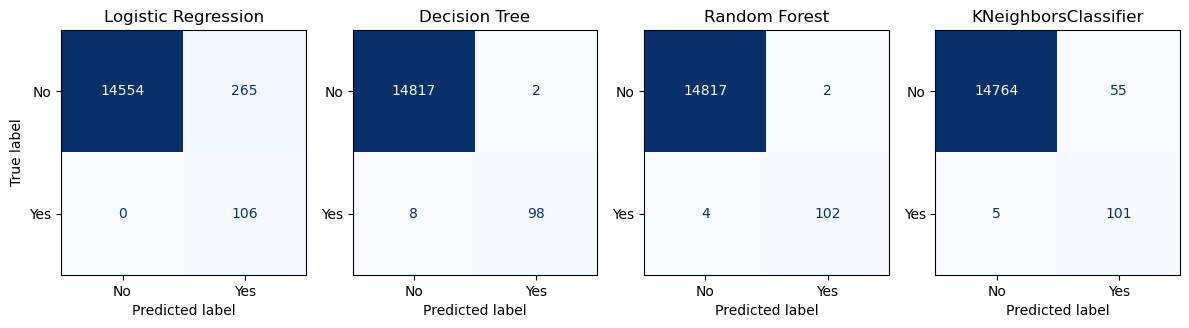

In [ ]:
models = [lgr, dtree, rf, knn]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNeighborsClassifier']

fig, axes = plt.subplots(1, 4, figsize=(12, 6))

for i, (clf, name, ax) in enumerate(zip(models, model_names, axes.flatten())):
    cm = confusion_matrix(y_test, clf.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=ax, cmap='Blues' ,colorbar=False)
    ax.set_title(name)
    
    if i != 0:
        ax.set_ylabel('')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')


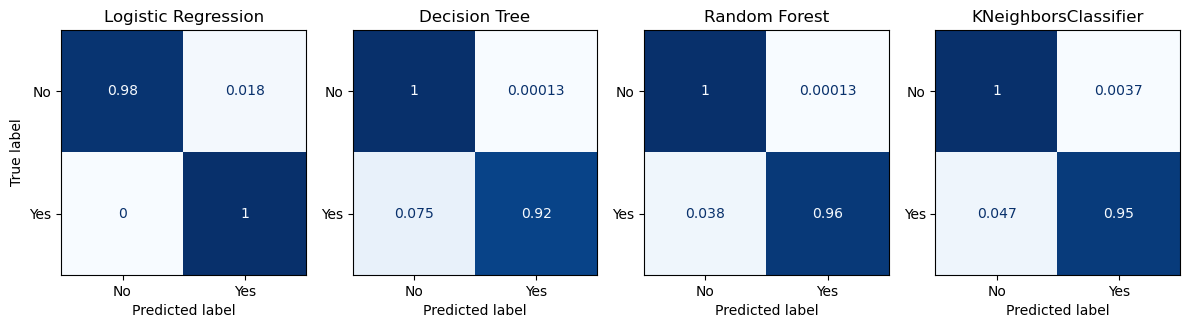

In [ ]:
models = [lgr, dtree, rf, knn]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNeighborsClassifier']

fig, axes = plt.subplots(1, 4, figsize=(12, 6))

for i, (clf, name, ax) in enumerate(zip(models, model_names, axes.flatten())):
    cm = confusion_matrix(y_test, clf.predict(X_test), normalize='true') 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=ax, cmap='Blues' ,colorbar=False) 
    ax.set_title(name)
    
    if i != 0:
        ax.set_ylabel('')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')

### Feature Importance

In [ ]:
features = pd.DataFrame({
    'feature': list(X.columns),
    'coefficient': [i for i in lgr.coef_[0]]
}).sort_values('coefficient', ascending=False)
features

,feature,coefficient
1,speed_mph,20.049178
7,vehicle_motion_status_ MOVING,8.898037
3,angular_distance,5.471167
8,vehicle_motion_status_ PARKED,-0.028083
4,radius,-0.057710
0,direction,-0.084502
2,acceleration_from_gps_speed,-0.149960
5,critical_speed,-3.726265
6,vehicle_motion_status_ IDLING,-24.499029


#### DTREE Feature Importance

In [215]:
dtree_importances = dtree.feature_importances_
dtree_feature_importances = pd.DataFrame({'Feature': dfr.columns, 'Importance': dtree_importances})
dtree_feature_importances = dtree_feature_importances.sort_values('Importance', ascending=False)
dtree_feature_importances

,Feature,Importance
5,critical_speed,0.953615
1,speed_mph,0.041107
4,radius,0.004796
3,angular_distance,0.000281
2,acceleration_from_gps_speed,0.000101
0,direction,0.000067
9,random_noise,0.000034
6,vehicle_motion_status_ IDLING,0.000000
7,vehicle_motion_status_ MOVING,0.000000
8,vehicle_motion_status_ PARKED,0.000000


In [214]:
p_importance = permutation_importance(dtree, X_train_resample_with_noise, y_train_resample, n_repeats=25, random_state=12)
p_importances = p_importance.importances_mean
p_importances

array([1.19248240e-03, 2.16671113e-01, 6.53383090e-03, 1.47275460e-01,
       2.04339677e-02, 2.89897503e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.72236200e-05])

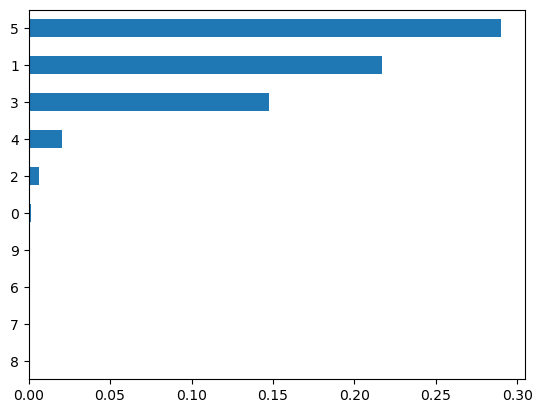

In [212]:
feat_importances = pd.Series(p_importances)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

#### RF Feature Importance

In [217]:

rf_importances = rf.feature_importances_

# Create a dataframe to display the feature importances
rf_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_importances})
rf_feature_importances = rf_feature_importances.sort_values('Importance', ascending=False)

# Display the feature importances
rf_feature_importances

,Feature,Importance
5,critical_speed,0.368854
3,angular_distance,0.320099
4,radius,0.175120
1,speed_mph,0.071372
7,vehicle_motion_status_ MOVING,0.041808
8,vehicle_motion_status_ PARKED,0.018262
0,direction,0.001967
2,acceleration_from_gps_speed,0.001785
6,vehicle_motion_status_ IDLING,0.000731
